## Explaining clusters
We use the shape values to understand how the GRDs are classified.

In [1]:
import numpy as np
from xgboost import XGBClassifier
import shap
import pandas as pd
import random

import xgboost
import shap
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree


/opt/miniconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
"is not" with a literal. Did you mean "!="?


We first load the feature matrix and the clustering index for each GRD.

In [2]:
name_model = "KMeans"
metric = "l2"
n_clusters = 4
cluster_dim = 5
preprocessing = "LogMinMax"
weighting_name = "energie"  # Change here the weighting ["economic","vuln","energie"]
if weighting_name is None:
    weighting_name = "None"

# Load the classification index
cluster_index_ = pd.read_csv(
    os.path.join(
        "../clusters",
        f"{preprocessing}_{cluster_dim}_{name_model}_{metric}_{n_clusters}_no_airport_conso_weighting_{weighting_name}.csv",
    )
)
# Load Feature matrix
aggregated_by_GRD = pd.read_csv(os.path.join("../data", f"aggregated_by_GRD.csv"),index_col=0)
classified = pd.merge(
    cluster_index_, aggregated_by_GRD, left_on="Name", right_index=True
)


 99%|===================| 2332/2348 [00:22<00:00]        

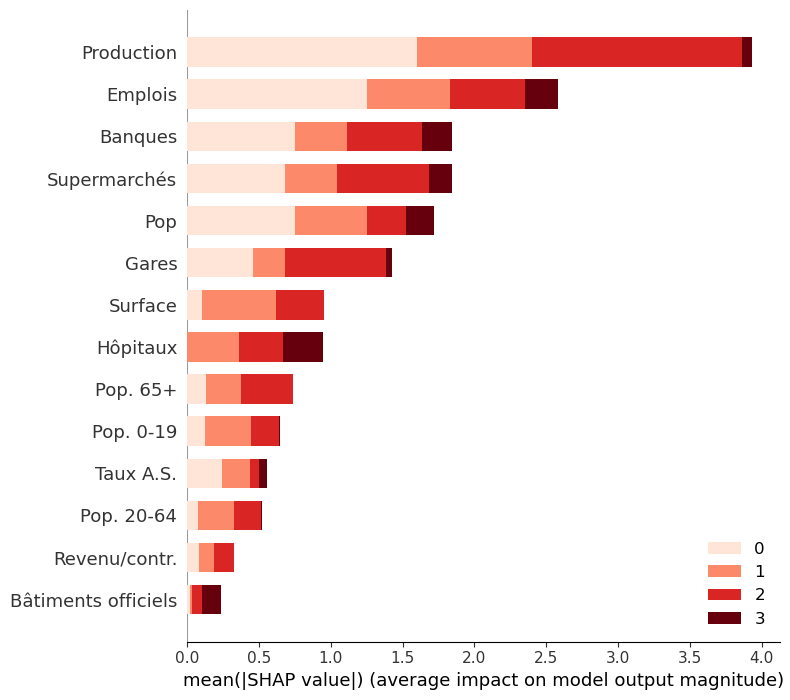

In [3]:
n_classes = 4
save = False
np.random.seed(0)
cmap = mpl.cm.Reds(np.linspace(0.1, 1, n_classes))
trad_col = {
    "train_station": "Gares",
    "bank": "Banques",
    "hospital": "Hôpitaux",
    "prod_plant_50MW": "Sites de production (less than 50MW)",
    "official_gov": "Bâtiments officiels",
    #'consumption':"HV station load",
    "supermarket": "Supermarchés",
}
abbr_col = {
    "Population - Habitants": "Pop",
    "Surface - Surface, total": "Surface",
    "Economie - Emplois, total": "Emplois",
    "Sites de production (less than 50MW)": "Production",
    "Population - Part du groupe d'âge 0-19 ans": "Pop. 0-19",
    "Population - Part du groupe d'âge 20-64 ans": "Pop. 20-64",
    "Population - Part du groupe d'âge 65+ ans": "Pop. 65+",
    "Taux d'aide sociale": "Taux A.S.",
    "Revenu imposable par contribuable, en francs": "Revenu/contr.",
}
X = (
    aggregated_by_GRD.reset_index(drop=True)
    .drop(columns=["airport_filtered", "consumption"])
    .rename(columns=trad_col)
    .rename(columns=abbr_col)
)


y = classified["cluster_index"].astype(int)
model = XGBClassifier(
    n_estimators=200, colsample_bytree=0.5, colsample_bylevel=0.5
).fit(X, y)

explainer = shap.TreeExplainer(
    model, X.sample(100), feature_perturbation="interventional"
)
shap_values = explainer.shap_values(X)
fig = shap.summary_plot(
    shap_values,
    X,
    plot_type="bar",
    feature_names=X.columns.tolist(),
    class_names=model.classes_,
    class_inds=np.arange(n_classes).tolist(),
    color=lambda x: cmap[x],
    show=False,
)

if save:
    plt.savefig(
        os.path.join(
            "../figure",
            f"shap_abs_cluster_{n_classes}_no_airport_conso_weighting_{weighting_name}.png",
        ),
        dpi=150,
    )


Cluster  0


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


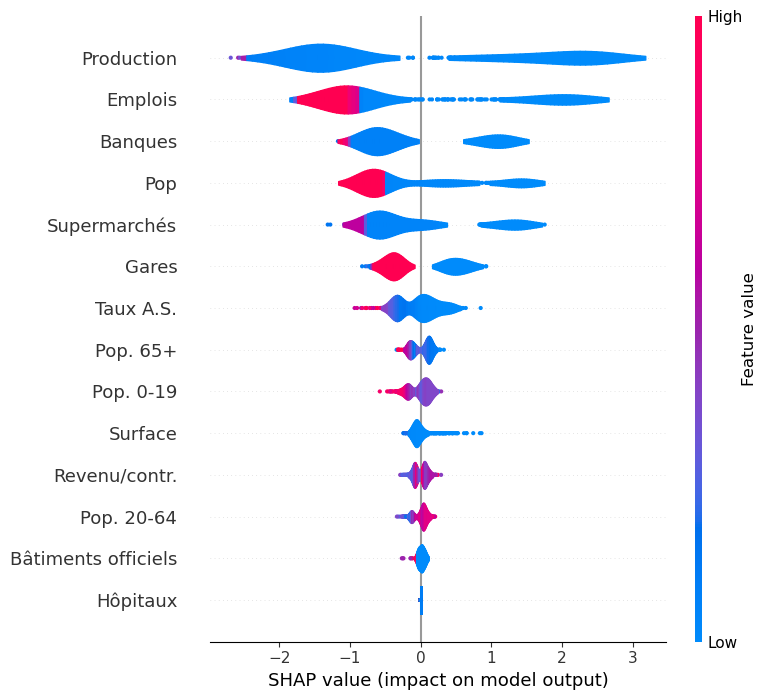

Cluster  1


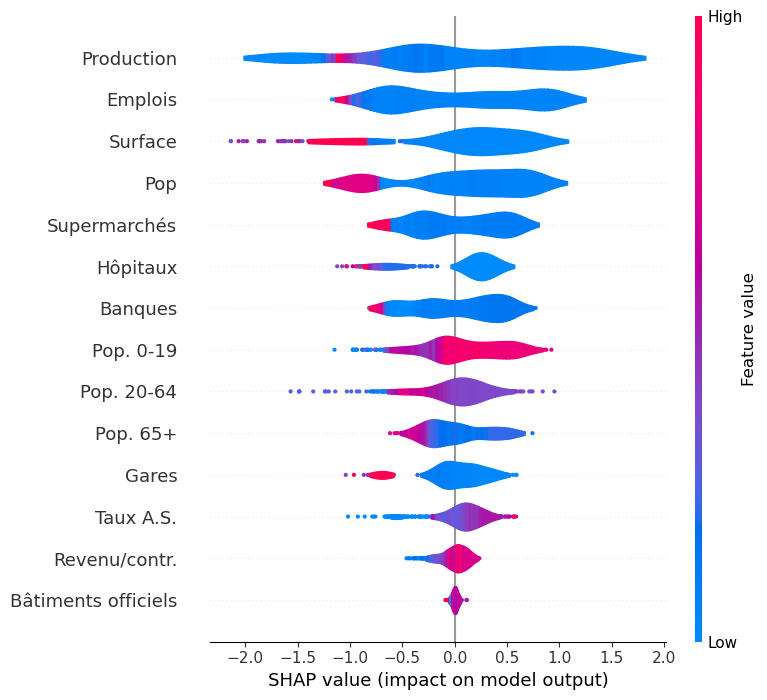

Cluster  2


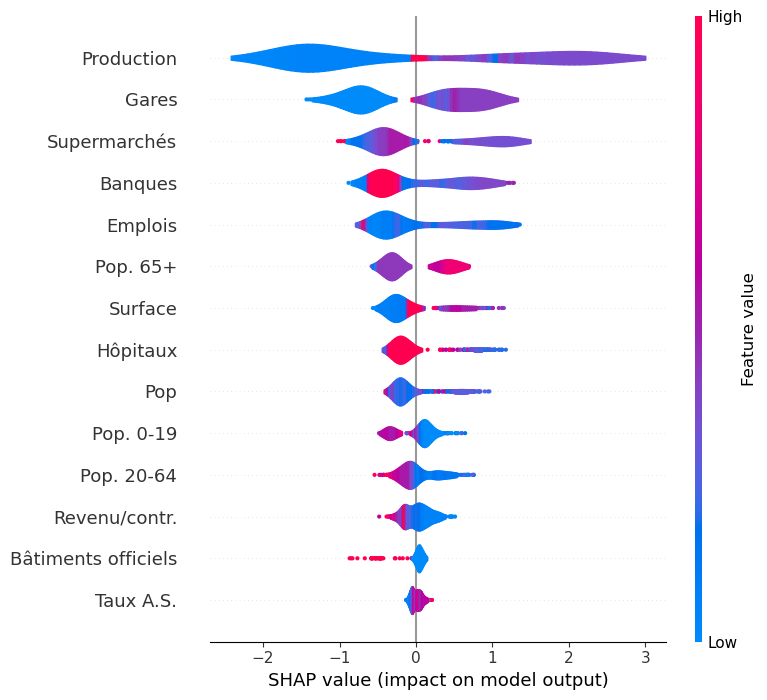

Cluster  3


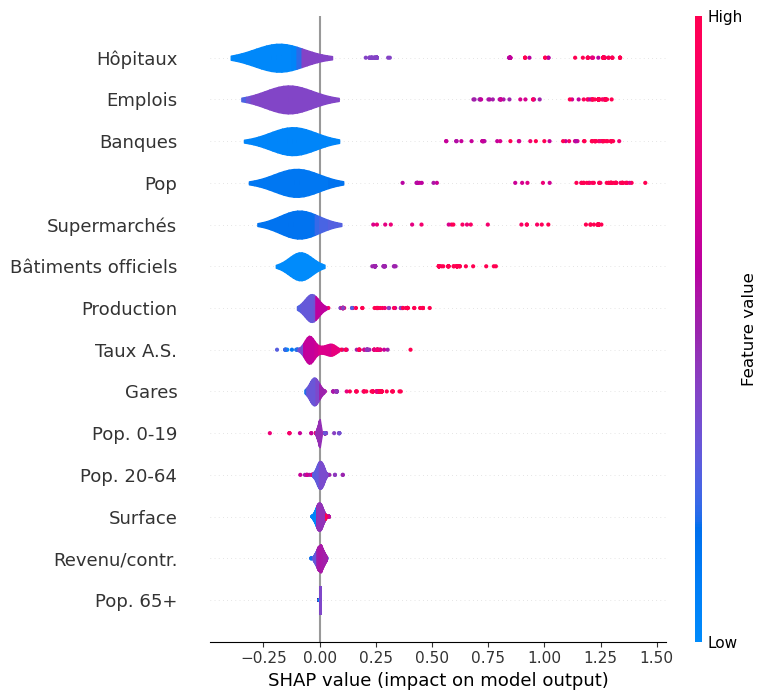

In [4]:
for class_index in range(4):
    print("Cluster ", class_index)
    cmap = mpl.cm.Reds(np.linspace(0.1, 1, n_classes))
    shap.summary_plot(shap_values[class_index], X, plot_type="violin")
    plt.show()


Impresa Elettrica Comunale Poschiavo


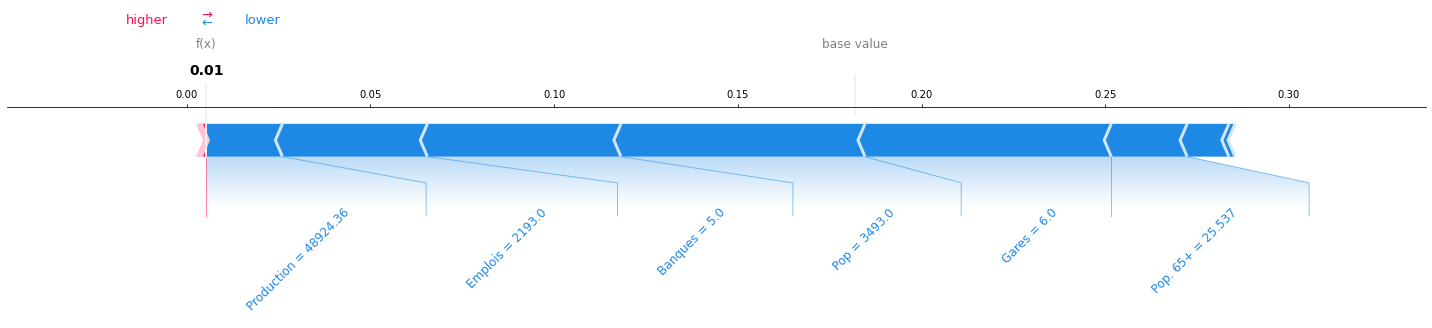

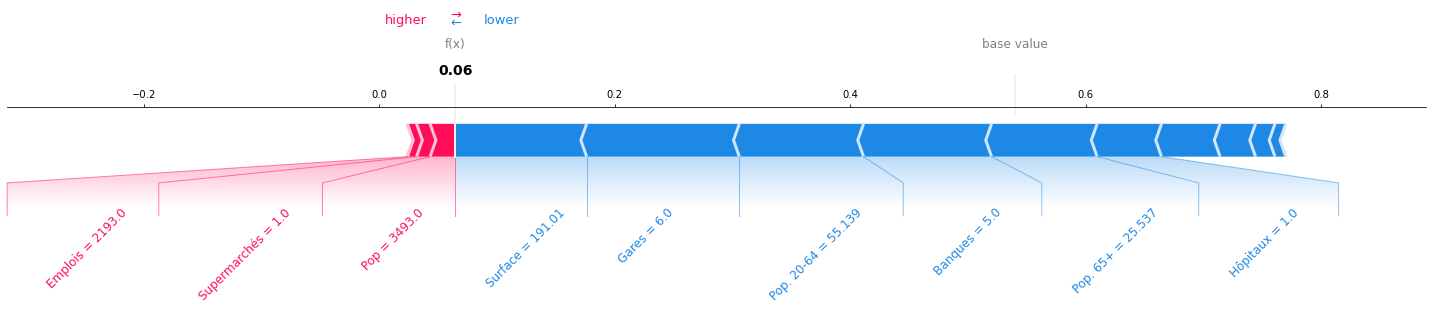

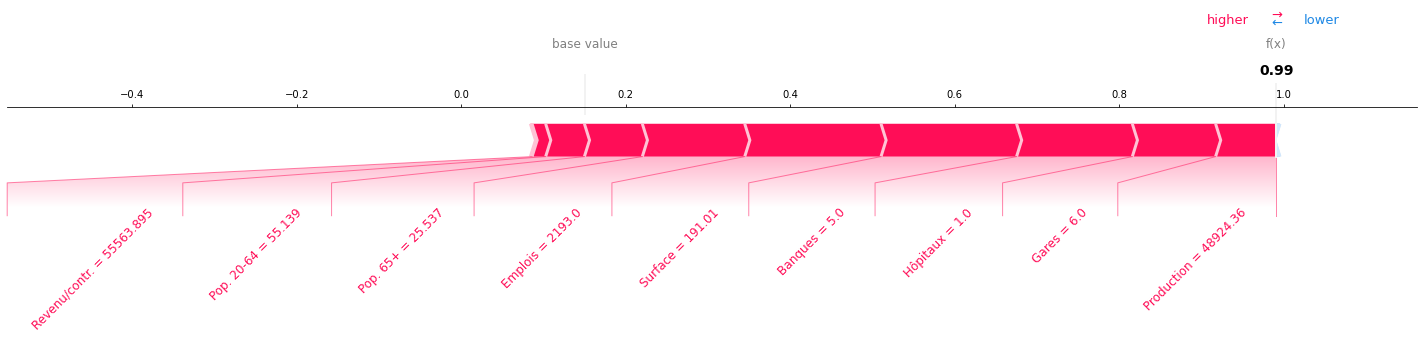

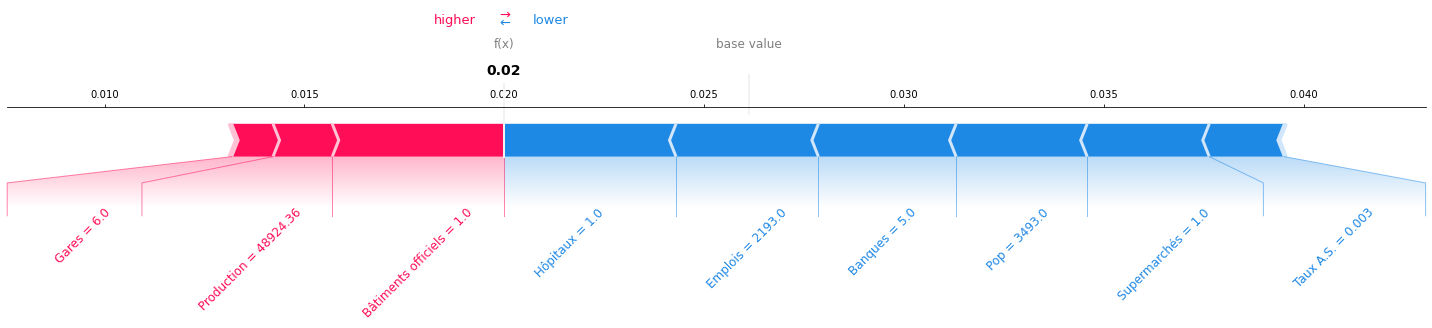

In [6]:
shap.initjs()
# choose your GRDs
example_index = 433
print(classified.iloc[example_index].Name)
save = False
for i in range(n_classes):
    x = shap.plots.force(
        explainer.expected_value[i],
        shap_values[i][example_index],
        X.iloc[example_index],
        show=False,
        matplotlib=True,
        figsize=(20, 5),
        link="logit",
        contribution_threshold=0.01,
        text_rotation=45,
    )
    plt.tight_layout()
    if save:
        plt.savefig(
            os.path.join(
                "../figure",
                f"shap_force_cluster_{n_classes}-cl_{i}_sample_{example_index}_no_airport_conso_weighting_{weighting_name}.png",
            ),
            dpi=150,
        )
    plt.show()


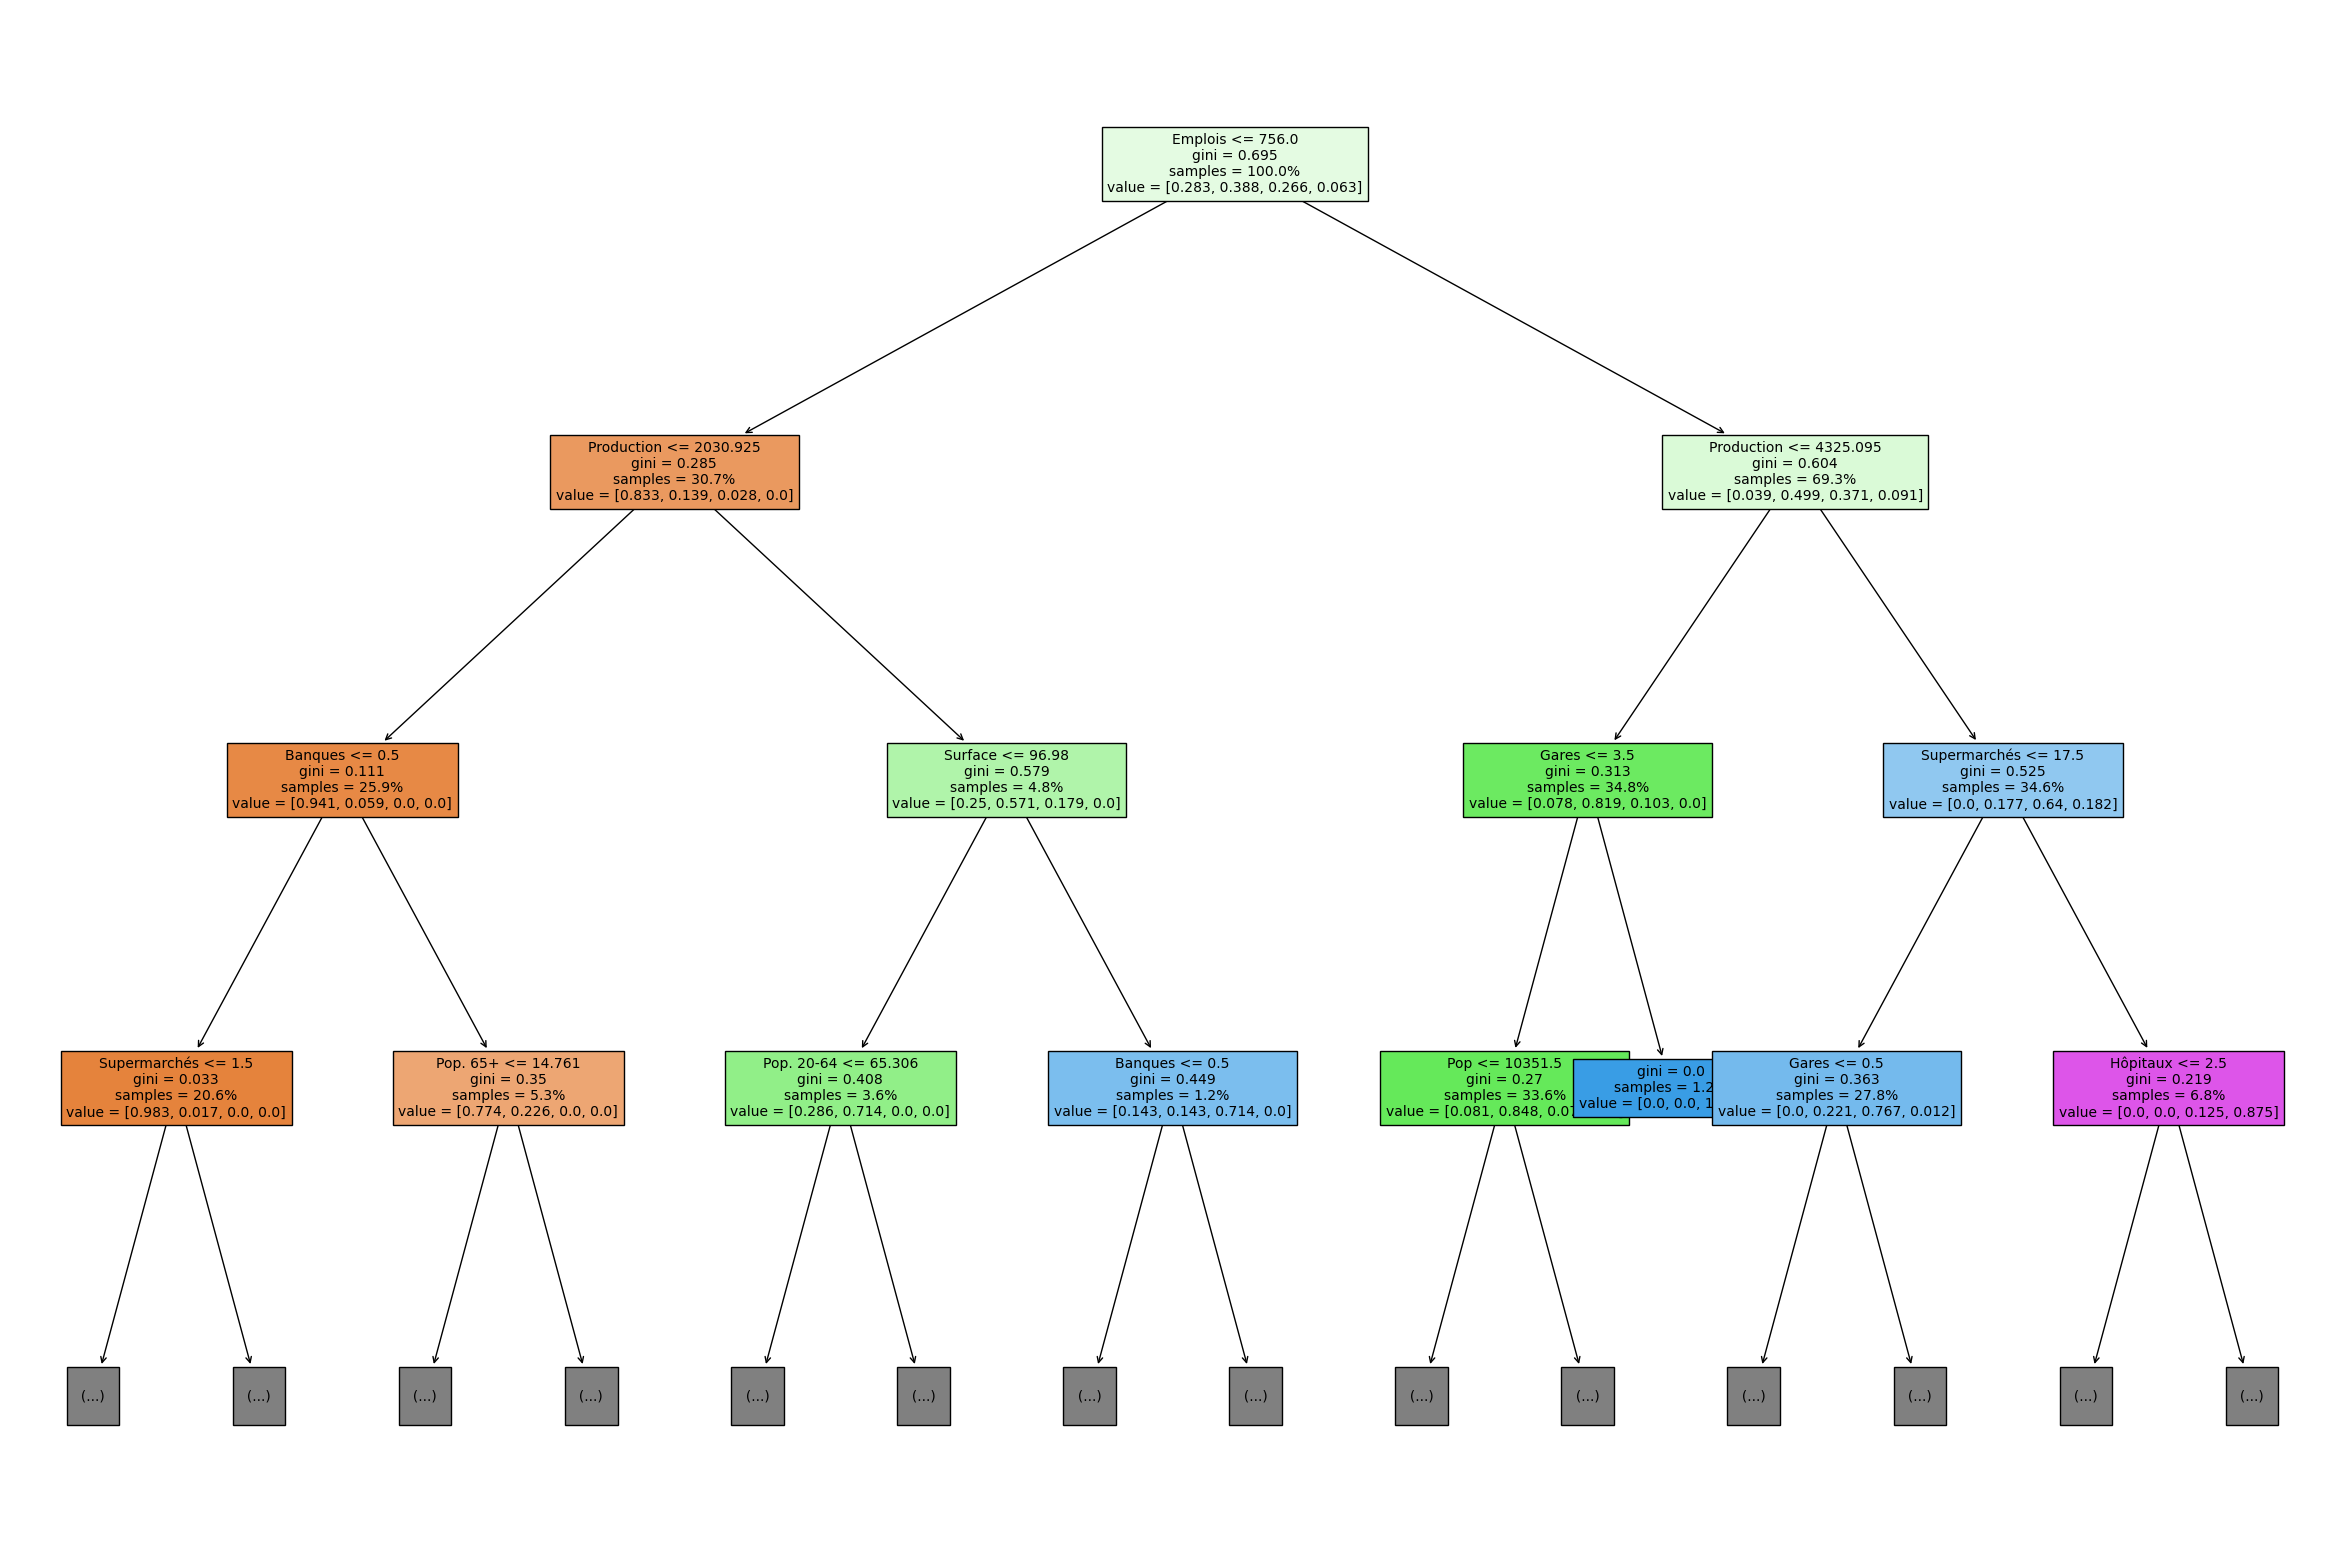

In [5]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=5).fit(X, y)

fig, ax = plt.subplots(figsize=(30, 20))
_ = plot_tree(
    tree,
    feature_names=X.columns,
    filled=True,
    ax=ax,
    fontsize=10,
    max_depth=3,
    proportion=True,
)
